<center> <h1> GROUP DATA ANALYSIS 3 </h1> <center>
<center> <h2> Logistical Regression </h2> <center>
<center> <h3> Luke Nichols and Jager Springer </h3> <center>

## Introduction

Our business question asks whether schools, teams, and coaches can use statistical metrics to identify the key factors leading a college basketball team into the postseason. Using a Kaggle dataset containing data on all NCAA Division I teams from 2013 to 2023, our analysis examines which statistical metrics, if any, are the best predictors of a team’s probability of making the NCAA tournament. Finally, we apply our model to predict the postseason probability based on the stats the Utah State’s 2024-2025 basketball team is expected to achieve throughout the season.

https://www.kaggle.com/code/yyue11/college-basketball-data-analysis

For our initial dataset, we will be using win percentage as our outcome variable and the following variables as predictor variables:

Continuous predictor variables:
- ADJOE (Adjusted Offensive Efficiency): Measures points scored per 100 possessions, adjusted for opponent strength.
- ADJDE (Adjusted Defensive Efficiency): Measures points allowed per 100 possessions, adjusted for opponent strength.
- BARTHAG: Represents the probability of a team beating an average Division I team on a neutral court.
- TOR (Offensive Turnover Rate): Calculates the percentage of a team’s possessions that result in a turnover.
- TORD (Defensive Turnover Rate): Measures the percentage of opponent possessions that result in a turnover.
- EFG_O (Effective Field Goal Percentage – Offense): Accounts for three-point shots by weighting them more in shooting efficiency.
- EFG_D (Effective Field Goal Percentage – Defense): Measures opponent shooting efficiency, factoring in three-point shots.
- FTR (Free Throw Rate – Offense): Shows how often a team gets to the free-throw line relative to field goal attempts.
- FTRD (Free Throw Rate – Defense): Measures how often opponents get to the free-throw line relative to their field goal attempts.
- ORB (Offensive Rebound Percentage): Calculates the percentage of available offensive rebounds a team secures.
- DRB (Defensive Rebound Percentage): Measures the percentage of available defensive rebounds a team secures.
- 2P_O (Two-Point Shot Percentage – Offense): Represents the shooting percentage for two-point field goals.
- 2P_D (Two-Point Shot Percentage – Defense): Measures the opponent’s two-point shooting percentage.
- 3P_O (Three-Point Shot Percentage – Offense): Represents the shooting percentage for three-point field goals.
- 3P_D (Three-Point Shot Percentage – Defense): Measures the opponent’s three-point shooting percentage.
- ADJ_T (Adjusted Tempo): Calculates the number of possessions per 40 minutes, adjusted for opponent pace.
- WinPct (Win Percentage): Number of games won divided by the total games played in the season.
- WAB (Wins Above Bubble): A team's extra wins beyond what a typical bubble team would have against its schedule

Categorical predictor variables:
- Conf (Conference)

#### Importing Libraries

In [1]:
# load packages here
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

#set seed
import random
random.seed(5600)

#### Reading in/filtering dataset

In [2]:
ncaa = pd.read_csv('/Users/lukenichols/Documents/DATA 5600/Group Data Analysis 3/modified_college_basketball_data.csv')

power_7_conferences = ["ACC", "B10", "B12", "P12", "WCC", "BE", "SEC", "MWC"]

# Assuming the conference column is named 'Conference'
ncaa = ncaa[ncaa["CONF"].isin(power_7_conferences)]

ncaa['POSTSEASON'] = ncaa['POSTSEASON'].astype(int)

ncaa.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,1,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,1,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,1,1.0,2017


### Discretizing Tempo Statistic

In [3]:
def categorize_tempo(atempo):
    if atempo <= 65:
        return 'Slow'
    elif 66 <= atempo <= 70:
        return 'Moderate'
    else:
        return 'Fast'

# Apply the function to create a new column
ncaa['tempo_category'] = ncaa['ADJ_T'].apply(categorize_tempo)

ncaa = ncaa.drop(columns='ADJ_T')
ncaa = ncaa.drop(columns='SEED')
ncaa = ncaa.drop(columns='YEAR')
ncaa['WinPct'] = ncaa["W"]/ncaa['G']
ncaa = ncaa.drop(columns='W')
ncaa = ncaa.drop(columns='G')
ncaa = ncaa.drop(columns='TEAM')
ncaa.head()

,CONF,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,WAB,POSTSEASON,tempo_category,WinPct
0,ACC,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,8.6,1,Fast,0.825000
1,B10,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,11.3,1,Slow,0.900000
2,B10,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,6.9,1,Fast,0.825000
3,B12,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,7.0,1,Moderate,0.815789
4,WCC,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,7.7,1,Fast,0.948718


We chose to discretize our tempo variable in order to give our model another qualitiative variable to use. We sorted the teams into three different categories: slow pace (less than 65 possessions per 40 minutes of gametime), moderate pace (between 66 to 70 possesions), and fast pace (greater than 70 possessions.) Moving forward in our model, moderate tempo will be used as our baseline.

In [4]:
ncaa.describe()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,WAB,POSTSEASON,WinPct
count,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000
mean,109.468267,97.494050,0.751816,50.678914,48.801044,17.922129,18.412735,30.422234,29.004071,34.977871,32.938518,49.980167,47.835595,34.623173,33.721712,-1.432463,0.417537,0.577885
std,6.442292,5.036487,0.176150,2.942368,2.702733,1.924519,2.205494,4.345646,3.037989,5.428125,5.868495,3.221963,3.143113,2.665556,2.307991,5.914780,0.493410,0.164197
min,86.200000,84.000000,0.075700,40.800000,39.600000,12.400000,12.400000,15.300000,18.400000,19.600000,19.100000,38.700000,37.700000,25.800000,26.500000,-21.400000,0.000000,0.000000
25%,105.400000,94.025000,0.667925,48.600000,47.000000,16.700000,16.900000,27.725000,27.000000,31.000000,28.625000,47.725000,45.700000,32.700000,32.200000,-5.400000,0.000000,0.468750
50%,109.300000,97.200000,0.805700,50.600000,48.700000,17.900000,18.300000,30.500000,29.100000,34.650000,32.400000,49.900000,47.750000,34.600000,33.600000,-1.100000,0.000000,0.591751
75%,113.600000,100.600000,0.880175,52.500000,50.600000,19.200000,19.700000,33.400000,31.100000,38.700000,36.700000,52.100000,49.900000,36.300000,35.300000,2.600000,1.000000,0.696640
max,129.100000,113.100000,0.984200,61.000000,58.900000,24.800000,28.000000,43.600000,39.000000,54.100000,56.900000,64.000000,60.600000,43.400000,42.000000,13.100000,1.000000,1.000000


## Exploratory Data Analysis

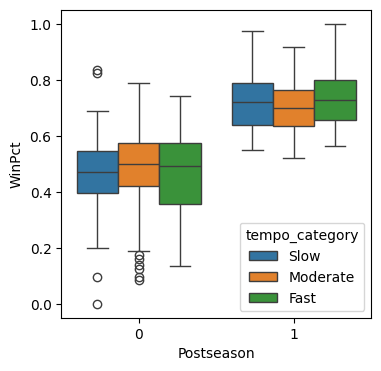

In [37]:
plt.figure(figsize = (4, 4))
sns.boxplot(data = ncaa,
                x = 'POSTSEASON', 
                y = 'WinPct', 
                hue = 'tempo_category'
                )
plt.xlabel('Postseason')
plt.ylabel('WinPct')
plt.show()

Tempo can have a much different trend on a team’s win percentage for postseason teams rather than non-postseason teams.
- Postseason: moderate tempo has the lowest, then slow tempo, and then fast tempo.
- Non-postseason: moderate tempo has the highest, then fast tempo, then slow tempo.

These trends can be for many reasons. Playing with a fast tempo is inherently more risky as while you have more opportunities to score, you are also creating more scoring opportunities for your opponent. Given this risk, it makes sense that higher level teams are able to overcome this risk easier, making fast tempo more effective for postseason teams while non-postseason teams are probably better sticking to a more moderate tempo of play.

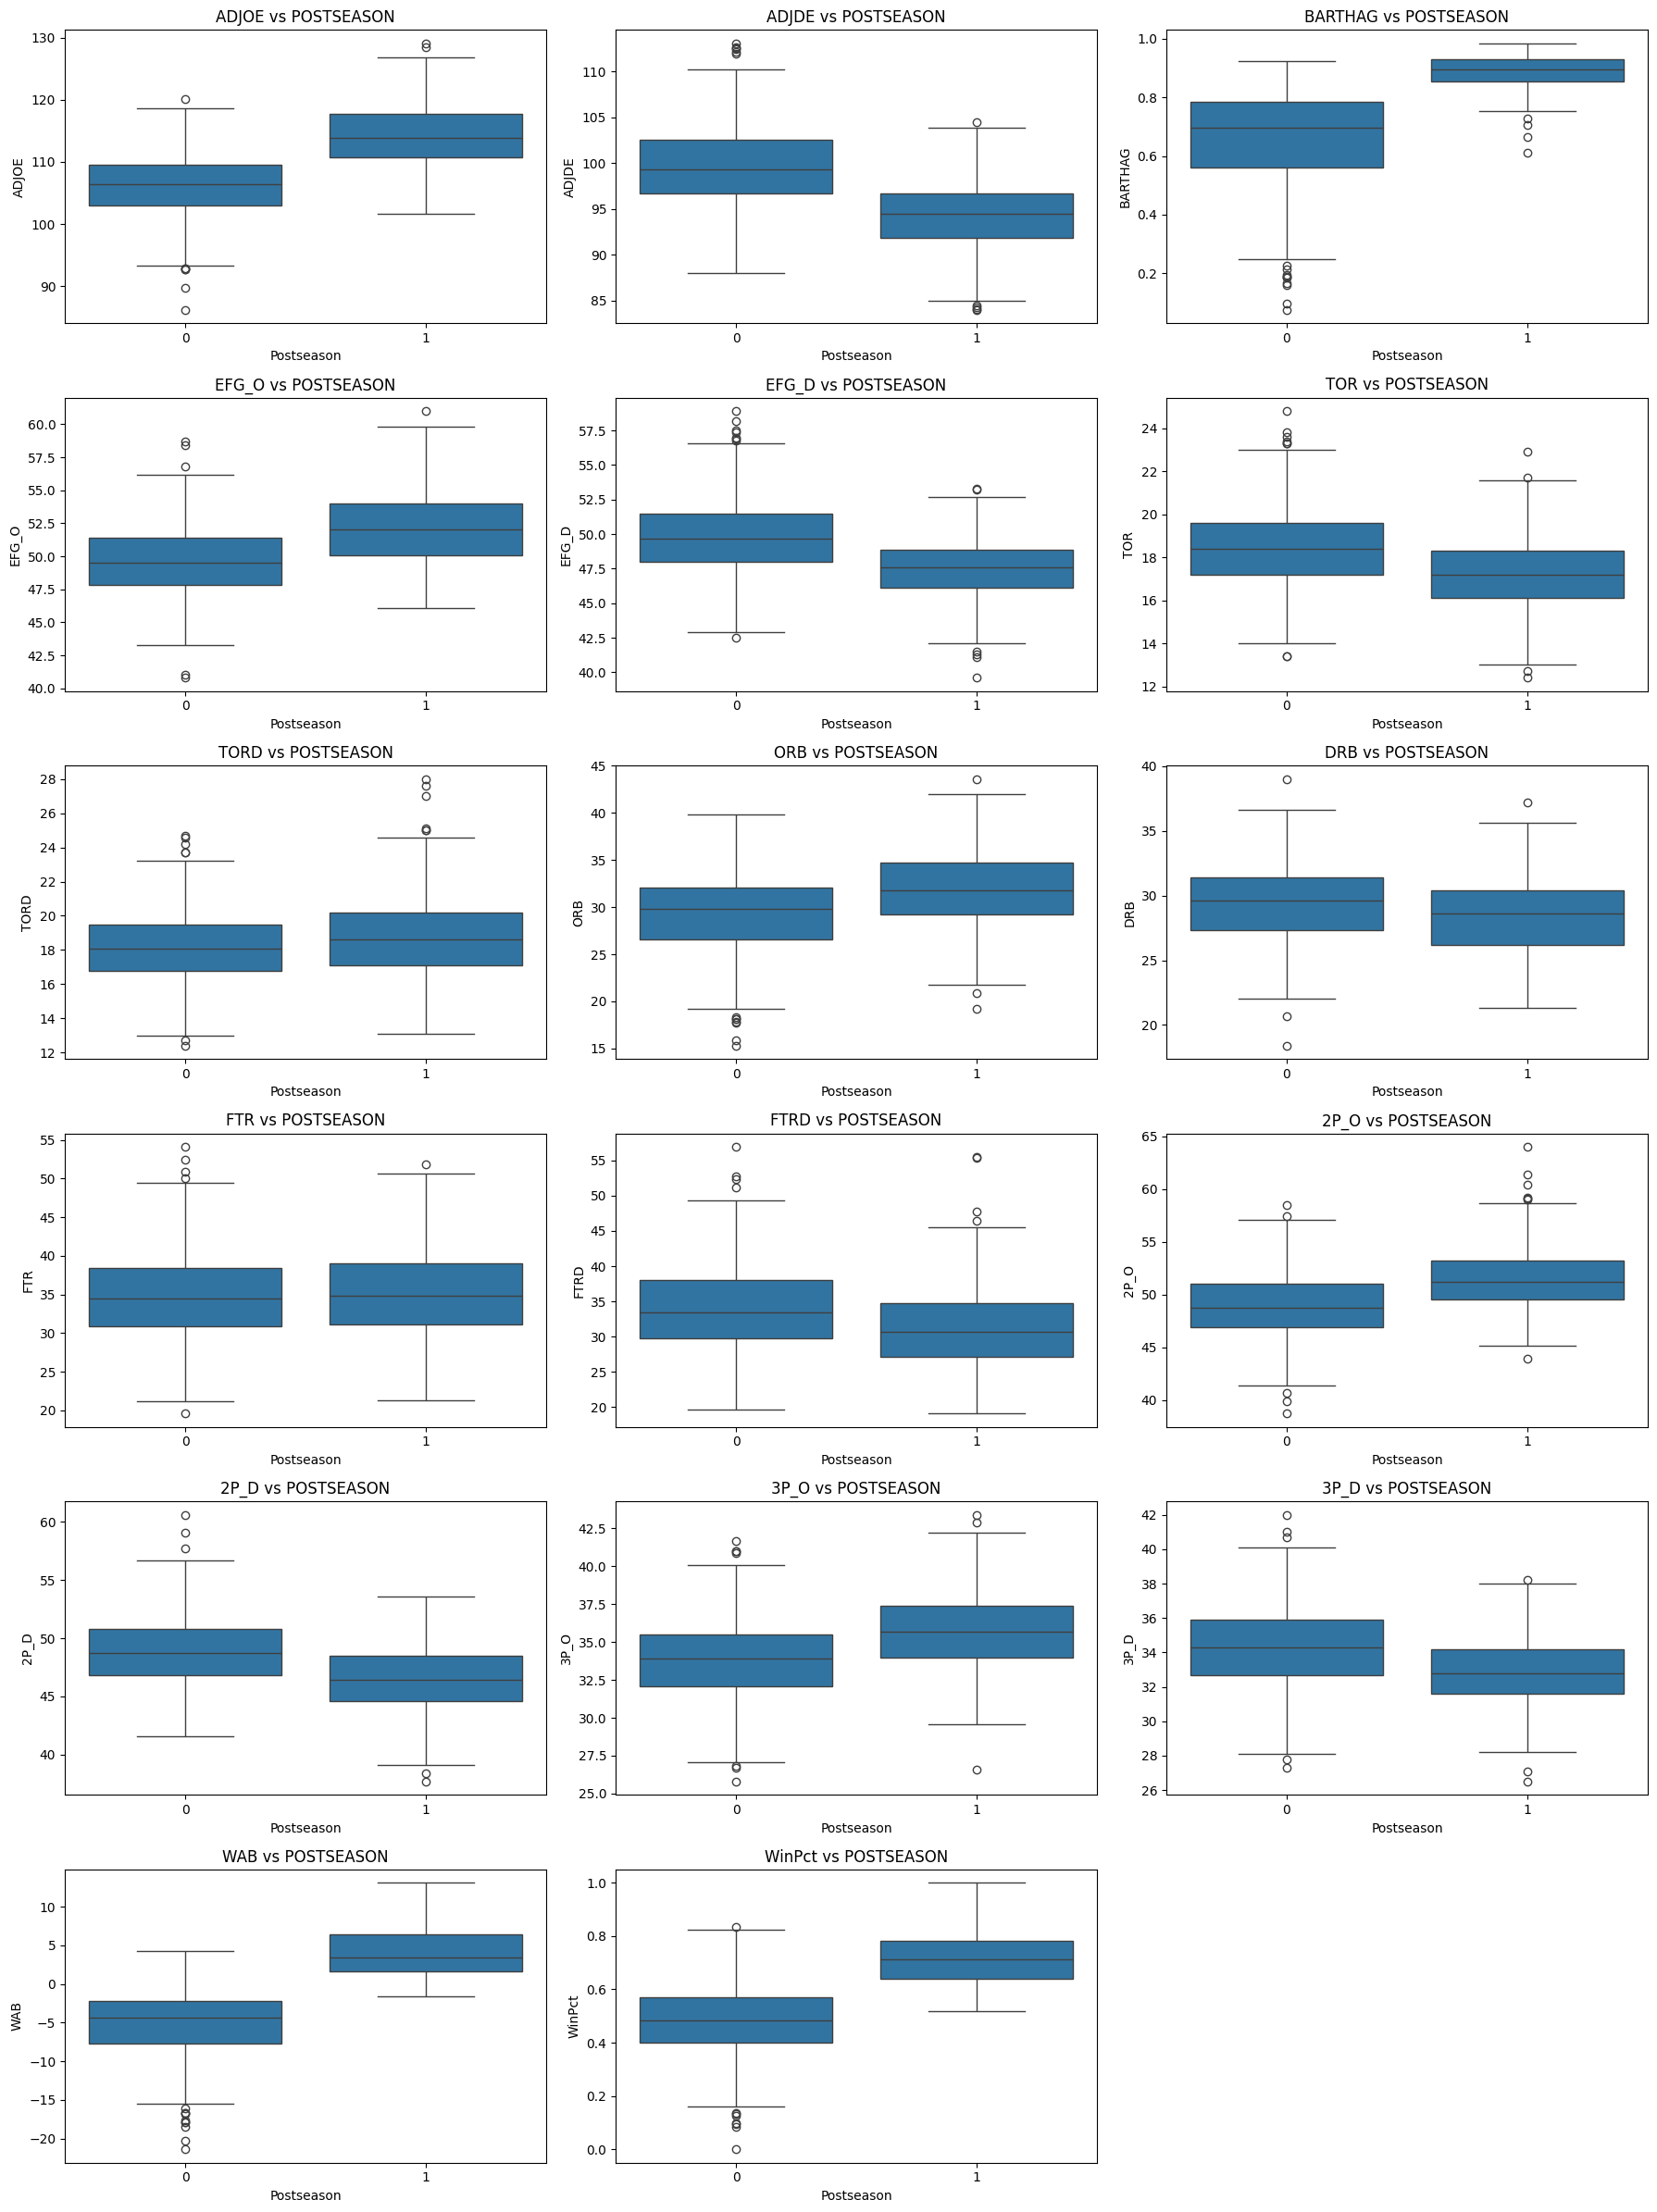

In [59]:
# Define the variables and titles
variables = [
    'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 'TORD',
    'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D',
    'WAB', 'WinPct'
]

# Set the number of subplots needed (e.g., 6 rows x 3 columns)
rows, cols = 6, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 24))

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through variables and create boxplots
for i, var in enumerate(variables):
    sns.boxplot(x='POSTSEASON', y=var, data=ncaa_dummy, ax=axes[i])
    axes[i].set_xlabel('Postseason')
    axes[i].set_ylabel(var)
    axes[i].set_title(f'{var} vs POSTSEASON')

# Hide any unused subplots (if any)
for j in range(len(variables), len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

Most of these statistics follow the logical pattern to be expected between postseason and non-postseason teams. Postseason teams on average are more efficient on offense and defense, shooting higher percentages on offense while limiting their opponents to lower shooting percentages. Smaller margins are shown between the two groups on FTR (free throw rate), meaning there is not as much variation between the two groups on this statistic.

## Calculating Our Baseline Accuracy

In [68]:
max_value_count = max(ncaa['POSTSEASON'].value_counts())

baseline_accuracy = max_value_count/len(ncaa['POSTSEASON'])

print('Baseline accuracy:', baseline_accuracy)

Baseline accuracy: 0.5824634655532359


Using the majority classifier technique, we can set a baseline accuracy of 58.2% if we were to just guess each time as not making the postseason in our dataset.

## Building Our Model

#### Creating Dummy Variables

In [5]:
ncaa_dummy = pd.get_dummies(ncaa,
                            columns=['CONF', 'tempo_category'])
ncaa_dummy['CONF_ACC'] = ncaa_dummy['CONF_ACC'].astype(int)
ncaa_dummy['CONF_B10'] = ncaa_dummy['CONF_B10'].astype(int)
ncaa_dummy['CONF_B12'] = ncaa_dummy['CONF_B12'].astype(int)
ncaa_dummy['CONF_BE'] = ncaa_dummy['CONF_BE'].astype(int)
ncaa_dummy['CONF_MWC'] = ncaa_dummy['CONF_MWC'].astype(int)
ncaa_dummy['CONF_P12'] = ncaa_dummy['CONF_P12'].astype(int)
ncaa_dummy['CONF_SEC'] = ncaa_dummy['CONF_SEC'].astype(int)
ncaa_dummy['CONF_WCC'] = ncaa_dummy['CONF_WCC'].astype(int)
ncaa_dummy['tempo_category_Slow'] = ncaa_dummy['tempo_category_Slow'].astype(int)
ncaa_dummy['tempo_category_Moderate'] = ncaa_dummy['tempo_category_Moderate'].astype(int)
ncaa_dummy['tempo_category_Fast'] = ncaa_dummy['tempo_category_Fast'].astype(int)


ncaa_dummy.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,WAB,POSTSEASON,WinPct,CONF_ACC,CONF_B10,CONF_B12,CONF_BE,CONF_MWC,CONF_P12,CONF_SEC,CONF_WCC,tempo_category_Fast,tempo_category_Moderate,tempo_category_Slow
0,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,8.6,1,0.825000,1,0,0,0,0,0,0,0,1,0,0
1,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,11.3,1,0.900000,0,1,0,0,0,0,0,0,0,0,1
2,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,6.9,1,0.825000,0,1,0,0,0,0,0,0,1,0,0
3,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,7.0,1,0.815789,0,0,1,0,0,0,0,0,0,1,0
4,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,7.7,1,0.948718,0,0,0,0,0,0,0,1,1,0,0


### Creating Training/Test Sets

In [6]:
y = ncaa_dummy['POSTSEASON']
X = ncaa_dummy.drop('POSTSEASON', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5600)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(766, 28) (766,)
(192, 28) (192,)


### Variable Selection

#### Backward Stepwise Selection

In [7]:
backward_selection = SFS(LogisticRegression(fit_intercept = True), 
                         k_features = (1, len(X.columns)), 
                         forward = False, 
                         floating = False,
                         scoring = 'neg_mean_squared_error',
                         cv = 5)

backward = backward_selection.fit(X_train, y_train)

print('Backward Stepwise Selection:', backward.k_feature_names_)

/Users/lukenichols/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lukenichols/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Backward Stepwise Selection: ('ADJOE', 'ADJDE', 'BARTHAG', 'TORD', 'ORB', 'FTR', '2P_O', '2P_D', '3P_O', '3P_D', 'WAB', 'CONF_ACC', 'CONF_B12', 'CONF_BE', 'CONF_P12', 'CONF_SEC', 'tempo_category_Fast', 'tempo_category_Moderate')


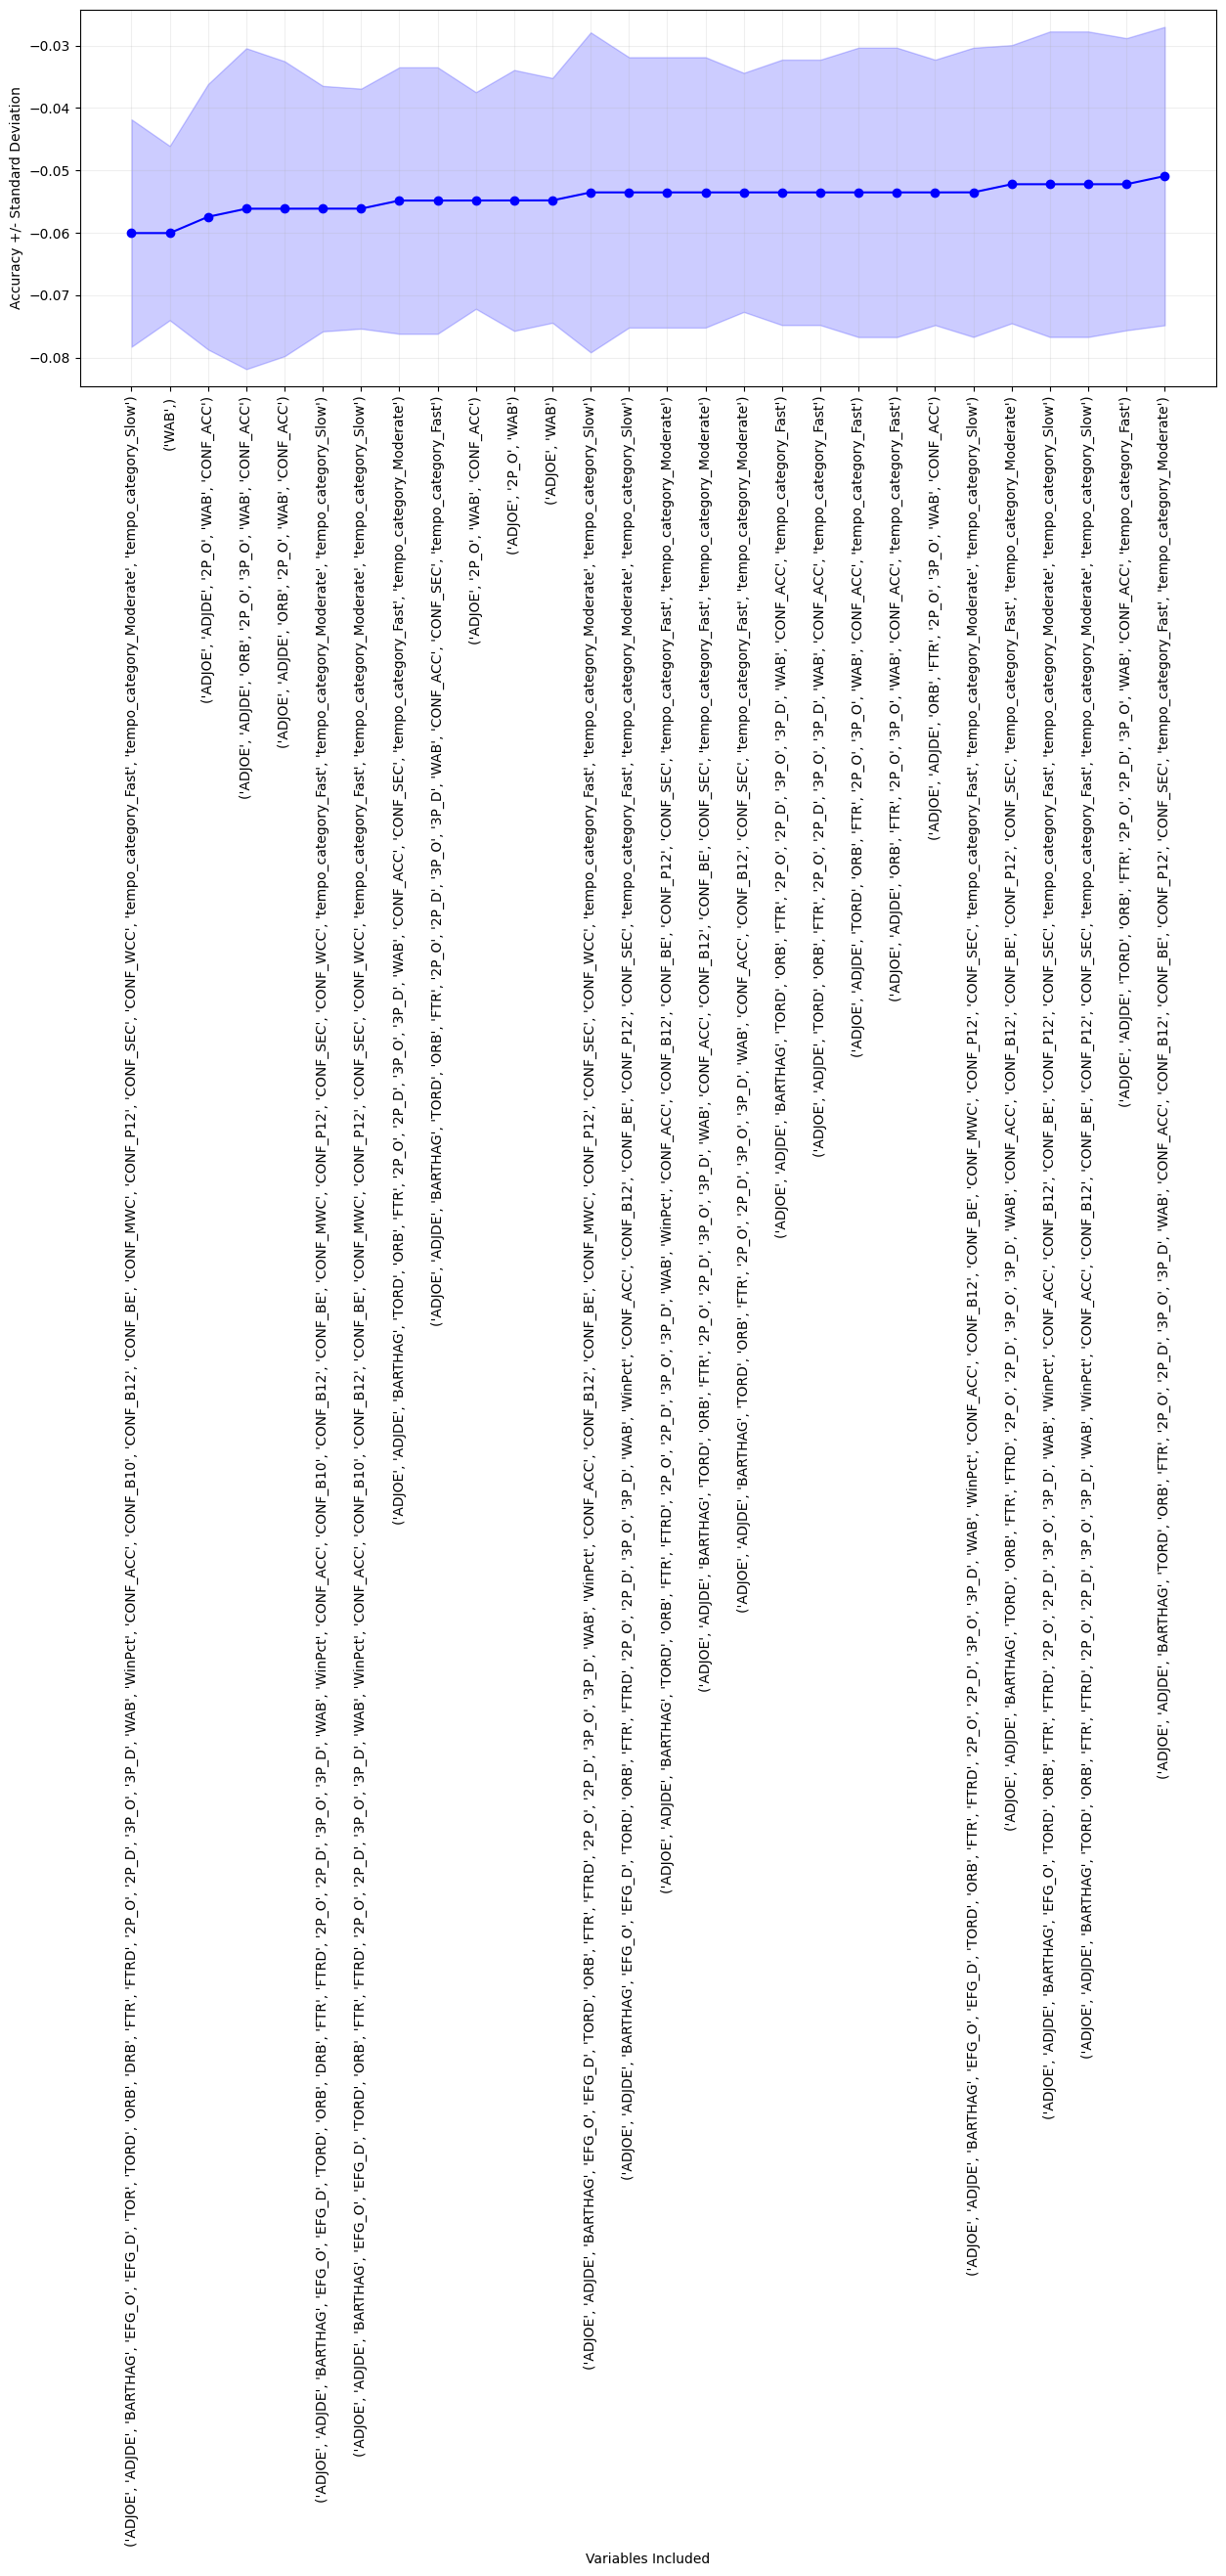

In [8]:
metric_dict = backward_selection.get_metric_dict()
x_axis = sorted(metric_dict.keys())

metric_dict_sorted = dict(sorted(metric_dict.items(), key = lambda x: x[1]['avg_score']))

fig = plt.figure(figsize = (15, 5))
k_feat = metric_dict_sorted.keys()
k_feat_list = list(k_feat)
avg = [metric_dict_sorted[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict_sorted[k]['avg_score'] +
                 metric_dict_sorted[k]['std_dev'])
    lower.append(metric_dict_sorted[k]['avg_score'] -
                 metric_dict_sorted[k]['std_dev'])
    
plt.fill_between(x_axis,
                 upper,
                 lower,
                 alpha = 0.2,
                 color = 'blue',
                 lw = 1)

plt.plot(x_axis, avg, color = 'blue', marker = 'o')
plt.ylabel('Accuracy +/- Standard Deviation')
plt.xlabel('Variables Included')
plt.xticks(x_axis, 
           [str(metric_dict_sorted[k]['feature_names']) for k in k_feat_list], 
           rotation = 90)
plt.grid(alpha = 0.2)
plt.show()

#### Elastic Net

In [9]:
# Create a list of possible alphas
potential_alphas = np.logspace(-4, 2, 500)

# run cross-validation to find the best alpha and l1_ratio
ElasticNetCV_model = ElasticNetCV(alphas = potential_alphas, 
                                  cv = 5, 
                                  random_state = 12345, 
                                  max_iter = 10000, 
                                  fit_intercept = True)
ElasticNetCV_model.fit(X_train, y_train)

# Get the list of alphas and corresponding MSEs
alphas = ElasticNetCV_model.alphas_
pmse_means = np.mean(ElasticNetCV_model.mse_path_, axis = 1)
pmse_std_error = np.std(ElasticNetCV_model.mse_path_, 
                        axis = 1,
                        ddof = 1) / np.sqrt(5)  # 5-fold CV

# Find the alpha that minimizes MSE
alpha_index_min = np.argmin(pmse_means)
alpha_min = alphas[alpha_index_min]

# Find the MSE that is one standard error away from the minimum MSE
one_se_above_min = min(pmse_means) + pmse_std_error[alpha_index_min]

# Find the largetst alpha with MSE less than or equal to one_se_above_min
alpha_index_1se = np.where(pmse_means <= one_se_above_min)[0][0]
alpha_1se = alphas[alpha_index_1se]

print("Minimum alpha:", alpha_min)
print("One SE alpha:", alpha_1se)

Minimum alpha: 0.0006945177773823696
One SE alpha: 0.006019481973827274


In [10]:
# Elastic Net results with lambda within one SE of the mean
en_1se = ElasticNet(alpha = alpha_1se,
                     fit_intercept = True)
en_1se.fit(X_train, y_train)

# Get coefficients
print(list(zip(en_1se.coef_, X_train)))

[(0.003416266428490355, 'ADJOE'), (-0.006144532475327165, 'ADJDE'), (-0.05383893648461039, 'BARTHAG'), (0.0, 'EFG_O'), (0.011147894168995599, 'EFG_D'), (-0.0013588813933411432, 'TOR'), (-0.00734799778229885, 'TORD'), (-0.00041105027385536166, 'ORB'), (0.0043907384625424374, 'DRB'), (-0.0024322112733527143, 'FTR'), (-0.0, 'FTRD'), (-0.009906322536331459, '2P_O'), (4.51533316007182e-06, '2P_D'), (0.006188931443453579, '3P_O'), (0.004927699448074655, '3P_D'), (0.06695897815603473, 'WAB'), (-0.0, 'WinPct'), (-0.04579218784724183, 'CONF_ACC'), (-0.0, 'CONF_B10'), (0.0, 'CONF_B12'), (-0.0, 'CONF_BE'), (0.09463008588279456, 'CONF_MWC'), (-0.0, 'CONF_P12'), (-0.01934052670359675, 'CONF_SEC'), (0.006291091188952943, 'CONF_WCC'), (-0.0, 'tempo_category_Fast'), (0.0, 'tempo_category_Moderate'), (0.0, 'tempo_category_Slow')]


In [11]:
# Elastic Net results with min(lambda)
en_min = ElasticNet(alpha = alpha_min,
                     fit_intercept = True)
en_min.fit(X_train, y_train)

# Get coefficients
print(list(zip(en_min.coef_, X_train)))

[(0.024184735530967345, 'ADJOE'), (-0.03645179869315729, 'ADJDE'), (-1.2357158505950305, 'BARTHAG'), (-0.0, 'EFG_O'), (0.020516988205687155, 'EFG_D'), (-0.004805169779070877, 'TOR'), (-0.01661527309372305, 'TORD'), (-0.00019843668446345387, 'ORB'), (0.009388263237134677, 'DRB'), (-0.0022680691916745757, 'FTR'), (0.0007063718538748676, 'FTRD'), (-0.010133091130197069, '2P_O'), (0.0, '2P_D'), (0.004954666353078897, '3P_O'), (0.004616583713025934, '3P_D'), (0.06699291853858101, 'WAB'), (-0.0, 'WinPct'), (-0.07263685569350548, 'CONF_ACC'), (-0.011874073465328743, 'CONF_B10'), (0.009157300129621012, 'CONF_B12'), (-0.013420677753649473, 'CONF_BE'), (0.12555859982737116, 'CONF_MWC'), (0.0, 'CONF_P12'), (-0.035138395109322575, 'CONF_SEC'), (0.01232709753713819, 'CONF_WCC'), (-0.01033823420992842, 'tempo_category_Fast'), (0.0054454039932491155, 'tempo_category_Moderate'), (0.0, 'tempo_category_Slow')]


Based on the results of our backward stepwise selection and Elastic Net, we chose to include the following variables in our logistic regression model:
- ADJOE (Adjusted Offensive Efficiency)
- ADJDE (Adjusted Defensive Efficiency)
- TORD (Turnover Rate - Defensive)
- ORB (Offensive Rebounding Rate)
- 2P_O (2 Point Field Goal Pct - Offensive)
- 3P_O (3 Point Field Goal Pct - Offensive)
- 3P_D (3 Point Field Goal Pct - Defensive)
- FTR (Free Throw Rate )
- Tempo Category (Slow, Moderate, and Fast)

We originally included BARTHAG and WAB in our model, but ran into serious multicolinearity issues. This made sense given that these two metrics are often calculated using some of the other statistics in our model. We chose to remove these variables, which fixed our multicolinearity problems.

### Running Our Model

In [12]:
X_train_subset = sm.add_constant(X_train[['ADJOE', 'ADJDE', 'TORD', 'ORB', 
                                            '2P_O', '3P_O', '3P_D', 'FTR', 'tempo_category_Slow',
                                            'tempo_category_Fast']])
mod = sm.Logit(y_train, X_train_subset)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.245072
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             POSTSEASON   No. Observations:                  766
Model:                          Logit   Df Residuals:                      755
Method:                           MLE   Df Model:                           10
Date:                Tue, 15 Apr 2025   Pseudo R-squ.:                  0.6396
Time:                        19:11:21   Log-Likelihood:                -187.73
converged:                       True   LL-Null:                       -520.87
Covariance Type:            nonrobust   LLR p-value:                1.078e-136
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.0324      5.623     -0.361      0.718     -13.053       8.988
ADJOE                   0.6031      0.063      9.512      0.000       0.479       0.727
ADJDE                  -0.5898      0.060     -9.875      0.000      -0.707      -0.473
TORD                   -0.0363      0.071     -0.511      0.609      -0.176       0.103
ORB                    -0.1051      0.042     -2.484      0.013      -0.188      -0.022
2P_O                   -0.0623      0.063     -0.986      0.324      -0.186       0.062
3P_O                   -0.0279      0.072     -0.390      0.697      -0.168       0.112
3P_D                   -0.0538      0.078     -0.689      0.491      -0.207       0.099
FTR                     0.0556      0.027      2.057      0.040       0.003       0.109
tempo_category_Slow    -0.1224      0.360     -0.340      0.734      -0.829       0.584
tempo_category_Fast     0.1870      0.310      0.603      0.547      -0.421       0.795
=======================================================================================

Possibly complete quasi-separation: A fraction 0.10 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In our model, we set our baseline value for tempo as moderate (or teams with an adjusted tempo between 66-70.) Below is our fitted logistic regression model:

$log(\frac{P(Postseason=1)}{P(Postseason=0)})$ = -2.0324 + 0.6031 * (ADJOE) - 0.5898 * (ADJDE) - 0.0363 * (TORD) - 0.1051 * (ORB) - 0.0623 * (2P_O) - 0.0279 * (3P_O) - 0.0538 * (3P_D) + 0.0556 * (FTR) - 0.1224 * (tempo_category_Slow=1) + 0.1870 * (tempo_category_Fast=1)

## Checking Assumptions

#### The X's vs log odds are linear (monotone in probability)

/Users/lukenichols/Library/Python/3.9/lib/python/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


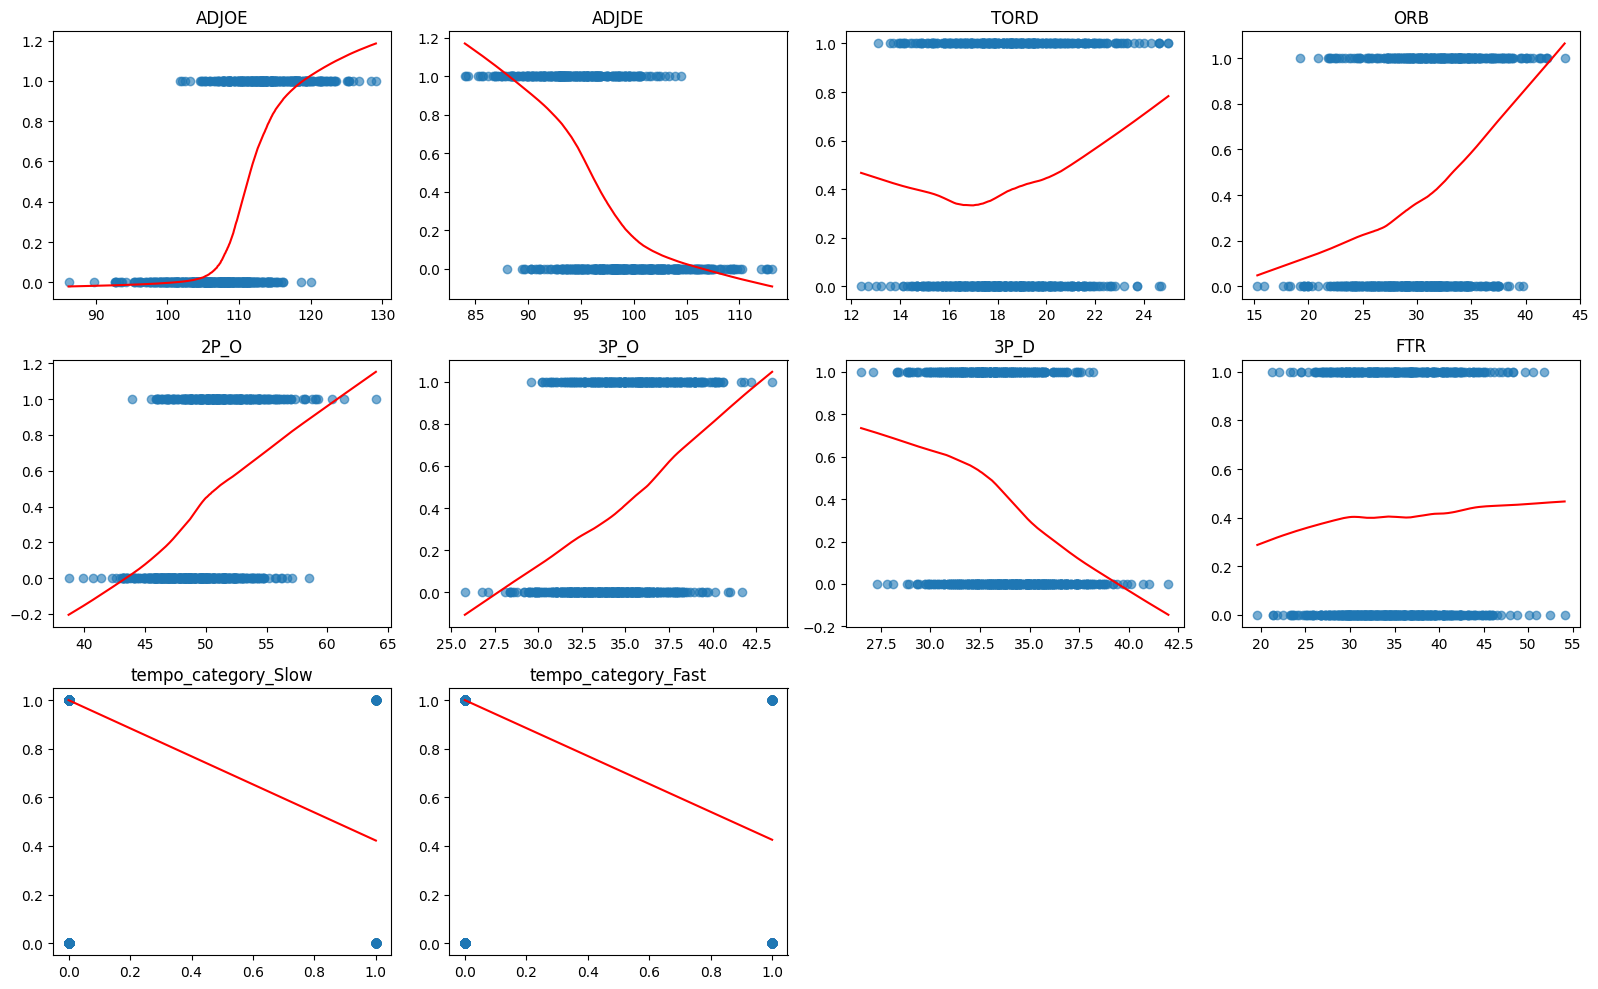

In [13]:

selected_vars = ['ADJOE', 'ADJDE', 'TORD', 'ORB', 
                 '2P_O', '3P_O', '3P_D', 'FTR', 
                 'tempo_category_Slow', 'tempo_category_Fast']

fig, ax = plt.subplots(3, 4, figsize=(16, 10))
ax = ax.flatten()

for i, var in enumerate(selected_vars):
    out = sm.nonparametric.lowess(y_train, X_train_subset[var])
    ax[i].scatter(X_train_subset[var], y_train, alpha=0.6)
    ax[i].plot(out[:, 0], out[:, 1], color='red')
    ax[i].set_title(var)

# Hide any unused subplots
for j in range(len(selected_vars), len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

Most of our plots looked really good, with the exception of TORD showing a U-shape, meaning it may not be very linear. As shown in a subsequent section of this report, we attempted transforming our TORD variable or including interactions between it and the other variables in our model. None of these attempts improved either the linearity of TORD or our model performance determined by our LLR p-value (as instructed to do so.) We decided to keep TORD in this state and have determined this assumption of linearity to be met.

#### The observations are independent 

Our data satisfies the independence assumption because each team appears only once per season, meaning there are no repeated measurements within the same year that could introduce dependency in the residuals.

#### The model describes all observations (i.e., there are no influential points)

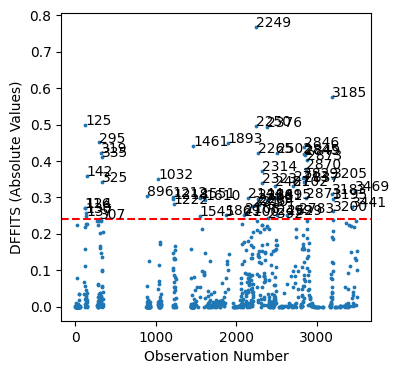

In [14]:
# DFFITS
X_train_subset['dffits'] = res.get_influence().summary_frame()['dffits_internal']

# plot DFFITS against the observation number
fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFFITS (Absolute Values)")
plt.xlabel("Observation Number")
plt.scatter(X_train_subset.index, np.abs(X_train_subset['dffits']), s = 3)
plt.axhline(y = 2 * np.sqrt(len(res.params) / len(X_train_subset)), color = 'r', linestyle = 'dashed')

#OPTIONAL: code to grab potential outliers
outliers = X_train_subset[np.abs(X_train_subset['dffits']) > 2 * np.sqrt(len(res.params) / len(X_train_subset))]
for i in list(outliers.index):
        plt.annotate(str(i), (i, np.abs(X_train_subset['dffits'][i])))
plt.show()

This assumption appears to be met with the exception of one possible influential point, observation 2249. Upon further reasearch, this was the 2015 Wyoming Cowboys, who despite a lackluster regular season, went on to win the Mountain West tournament, earning them an automatic bid to the NCAA tournament. This is referred to as a 'bid stealer', meaning the team wouldn't have made the NCAA torunament without receiving the automatic bid. In the higher conferences we are using in our model, bid stealers are quite uncommon, so it would make sense that a bid stealer team would be a potential influential point.

#### Additional predictor variables are not required

This assumption is likely not met, as other predictor variables could be very helpful in calculating postseason probability. The predictor variable that would be most likely to strengthen our model would be strength of schedule/number of quad 1 victories, as our current model would assume that all teams play the same schedule or difficulty of schedule, which is not true.

#### No multicollinearity (Use variance inflation factors)

In [15]:
ncaa_logistic_vifs = pd.DataFrame()
ncaa_logistic_vifs['Feature'] = X_train_subset.columns[1:11]
ncaa_logistic_vifs['VIF'] = [vif(X_train_subset, i) for i in range(1, len(X_train_subset.columns[0:11]))]

print("Max = ", max(ncaa_logistic_vifs['VIF']))
print("Mean = ", np.mean(ncaa_logistic_vifs['VIF']))
ncaa_logistic_vifs

Max =  3.9552552471904234
Mean =  1.8484194209652915


,Feature,VIF
0,ADJOE,3.955255
1,ADJDE,2.170975
2,TORD,1.261320
3,ORB,1.843024
4,2P_O,2.240594
5,3P_O,1.941277
6,3P_D,1.594440
7,FTR,1.165242
8,tempo_category_Slow,1.177650
9,tempo_category_Fast,1.134417


This assumption appears to be met as none of our variables have variance inflation factors very high. ADJOE has the highest VIF of 3.955, but this not high enough to be very concerned. We originally had an issue with multicolinearity, but we eliminated those variables of concern from our model.

#### Check Transformations for TORD

In [78]:
# X_train['TORD_sq'] = (X_train['TORD'])**2

# X_train_subset = sm.add_constant(X_train[['ADJOE', 'ADJDE', 'TORD_sq', 'ORB', 
#                                             '2P_O', '3P_O', '3P_D', 'FTR', 'tempo_category_Slow',
#                                             'tempo_category_Fast']])
# mod = sm.Logit(y_train, X_train_subset)
# res = mod.fit()
# res.summary()

/Users/lukenichols/Library/Python/3.9/lib/python/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


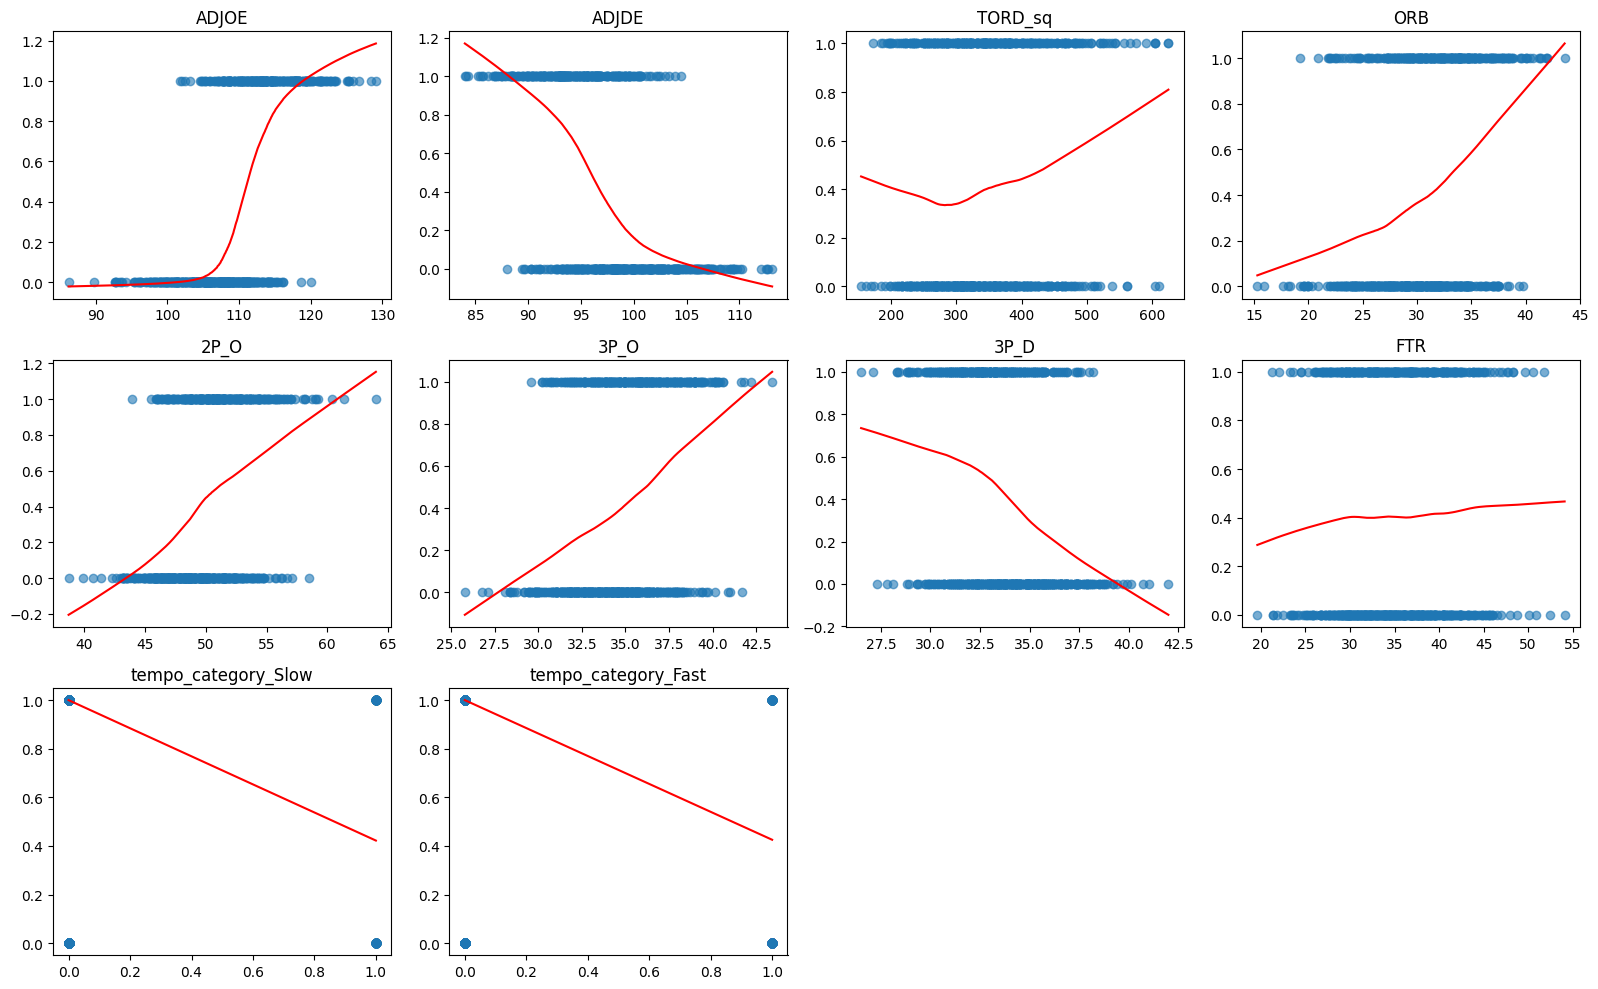

In [62]:

selected_vars = ['ADJOE', 'ADJDE', 'TORD_sq', 'ORB', 
                 '2P_O', '3P_O', '3P_D', 'FTR', 
                 'tempo_category_Slow', 'tempo_category_Fast']

fig, ax = plt.subplots(3, 4, figsize=(16, 10))
ax = ax.flatten()

for i, var in enumerate(selected_vars):
    out = sm.nonparametric.lowess(y_train, X_train_subset[var])
    ax[i].scatter(X_train_subset[var], y_train, alpha=0.6)
    ax[i].plot(out[:, 0], out[:, 1], color='red')
    ax[i].set_title(var)

# Hide any unused subplots
for j in range(len(selected_vars), len(ax)):
    ax[j].set_visible(False)

plt.tight_layout()
plt.show()

As shown above, we attempted transforming TORD by squaring it to attempt to improve its linearity. This transformation, along with other attempted transformations, were shown to be unsuccessful. We decided to keep the variable untransformed in our model.

#### Check for Interaction involving TORD

In [16]:
# Add interaction term
inter_X_train_subset = X_train_subset
inter_X_train_subset['TORD_ADJDE'] = inter_X_train_subset['TORD'] * inter_X_train_subset['FTR']

# Create X with interaction term included
X = sm.add_constant(inter_X_train_subset[['ADJOE', 'ADJDE', 'TORD', 'ORB', 
                                    '2P_O', '3P_O', '3P_D', 'FTR', 
                                    'tempo_category_Slow', 'tempo_category_Fast', 
                                    'TORD_ADJDE']])

# Fit the logistic regression model
mod = sm.Logit(y_train, X)
inter_res = mod.fit()

# View the summary
inter_res.summary()

Optimization terminated successfully.
         Current function value: 0.244781
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             POSTSEASON   No. Observations:                  766
Model:                          Logit   Df Residuals:                      754
Method:                           MLE   Df Model:                           11
Date:                Tue, 15 Apr 2025   Pseudo R-squ.:                  0.6400
Time:                        19:11:43   Log-Likelihood:                -187.50
converged:                       True   LL-Null:                       -520.87
Covariance Type:            nonrobust   LLR p-value:                7.251e-136
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.4187      8.590     -0.747      0.455     -23.254      10.417
ADJOE                   0.6073      0.064      9.501      0.000       0.482       0.733
ADJDE                  -0.5940      0.060     -9.862      0.000      -0.712      -0.476
TORD                    0.2104      0.374      0.563      0.573      -0.522       0.943
ORB                    -0.1078      0.042     -2.537      0.011      -0.191      -0.025
2P_O                   -0.0645      0.063     -1.019      0.308      -0.189       0.060
3P_O                   -0.0297      0.072     -0.413      0.679      -0.170       0.111
3P_D                   -0.0519      0.078     -0.665      0.506      -0.205       0.101
FTR                     0.1898      0.202      0.942      0.346      -0.205       0.585
tempo_category_Slow    -0.1307      0.361     -0.362      0.717      -0.838       0.577
tempo_category_Fast     0.1828      0.310      0.590      0.555      -0.425       0.791
TORD_ADJDE             -0.0073      0.011     -0.672      0.502      -0.029       0.014
=======================================================================================

Possibly complete quasi-separation: A fraction 0.10 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

We also attempted many interactions between many of our variables, most notably with TORD due to some of its linearity issues shown. We compared LLR p-values to determine whether a model with interactions performed better than our original model without interactions. In every interaction model we experimented with, none of them improved upon our original LLR p-value of 1.078e-136, so we concluded that we should not include any interactions in our model.

## Model Assessment

#### LLR P-value

1.078e-136

This LLR p-value is very small, which means we can confidently reject our null hypothesis, meaning at least one of the predictors in our model is significant in predicting whether or not a team will make the postseason. In other words, our model performs better than a model with no predictor variables would perform.

#### Confusion Matrix

In [17]:
possible_cutoffs = np.linspace(0, 1, 100)
percent_misclass = np.ones(100)
predicted_probabilities = np.exp(res.fittedvalues) / (1 + np.exp(res.fittedvalues))
    
for i in range(len(possible_cutoffs) - 1):
  cutoff = possible_cutoffs[i]
  classify = (predicted_probabilities > cutoff).astype(int)
  percent_misclass[i] = np.mean((classify != y_train.astype(int)).astype(int))

cutoff = possible_cutoffs[np.argmin(percent_misclass)]
cutoff

0.494949494949495

A cutoff value of 0.495 means that according to our model, a team with a probability of making the postseason greater than this value will be classified as making the postseason. Any team with a postseason probability less than or equal to this cutoff value will be classified as not making the postseason.

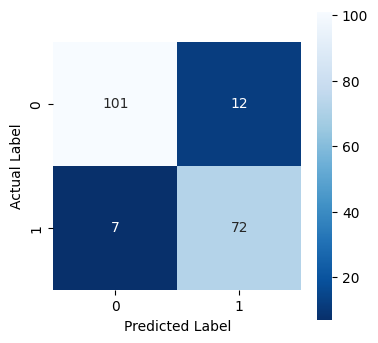

In [18]:
# Get predicted probabilities for the test data set
X_test_subset = sm.add_constant(X_test[['ADJOE', 'ADJDE', 'TORD', 'ORB', 
                                        '2P_O', '3P_O', '3P_D', 'FTR', 'tempo_category_Slow',
                                        'tempo_category_Fast']])
pred_probs_test = res.predict(X_test_subset)

# Use the cutoff to get predicted classifications of 0/1
preds_test = (pred_probs_test > cutoff).astype(int)
# Get confusion matrix
conf_mat = confusion_matrix(y_test, preds_test)

# Confusion matrix with labels
plt.figure(figsize = (4, 4))
sns.heatmap(conf_mat, 
            annot = True, 
            fmt = ".0f", 
            square = True, 
            cmap = 'Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

#### Specificity

In [56]:
101/(101+12)

0.8938053097345132

Roughly 89.38% of the teams in our model who did not make the postseason were correctly classified as not making the postseason by our model.

#### Sensitivity

In [57]:
72/(72+7)

0.9113924050632911

Roughly 91.1% of the teams in our model who did make the postseason were correctly classified as making the postseason by our model.

#### Percent Correctly Classified

In [58]:
(72+101)/(72+101+12+7)

0.9010416666666666

Our model was 90.1% accurate in classifying teams on whether or not they made the postseason in the given season. This is much improved of our baseline accuracy used of 58.2%.

#### AUC

In [22]:
roc_auc_score(y_test, pred_probs_test)

0.9684104402374818

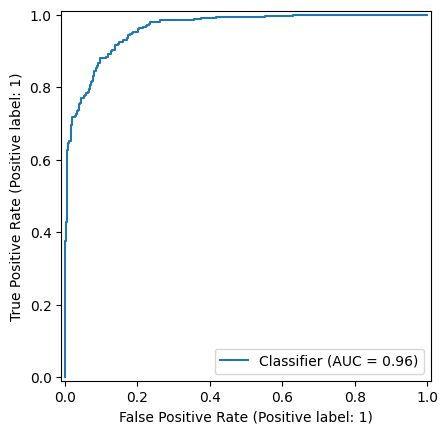

0.9616717420980783

In [55]:
RocCurveDisplay.from_predictions(y_train, predicted_probabilities)
plt.show()
roc_auc_score(y_train, predicted_probabilities)

## Statistical Inference

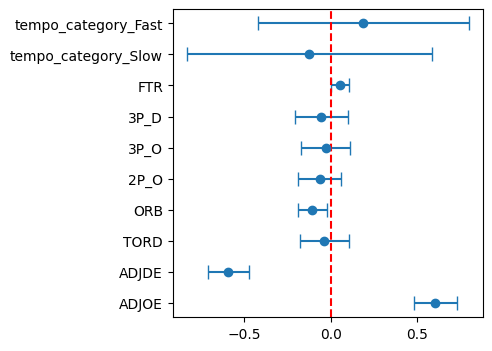

In [23]:
# Construct confidence interval data frame.
res_int = {
    'term': res.conf_int().index.tolist(),
    'coef': res.params.tolist(),
    'conf_low': res.conf_int().loc[:, 0].tolist(),
    'conf_high': res.conf_int().loc[:, 1].tolist()
}

df = pd.DataFrame(res_int)

# Selecting just slopes
df = df[df['term'] != 'const']

# Plotting the confidence interval
plt.figure(figsize=(4, 4))
# plt.errorbar(df['term'], df['coef'], 
#              yerr=[df['coef'] - df['conf_low'], df['conf_high'] - df['coef']], 
#              fmt='o', capsize=5, label='Estimates')
# plt.axhline(0, color='red', linestyle='--', label='y=0')
plt.errorbar(df['coef'], df['term'],
             xerr=[df['coef'] - df['conf_low'], df['conf_high'] - df['coef']], 
             fmt='o', capsize=5, label='Estimates')
plt.axvline(0, color='red', linestyle='--', label='y=0')

In [24]:
res.conf_int()

,0,1
const,-13.052610,8.987725
ADJOE,0.478838,0.727375
ADJDE,-0.706863,-0.472737
TORD,-0.175680,0.103006
ORB,-0.187987,-0.022178
2P_O,-0.186093,0.061506
3P_O,-0.168224,0.112404
3P_D,-0.207015,0.099355
FTR,0.002629,0.108607
tempo_category_Slow,-0.828917,0.584123


Looking at the confidence intervals for the coefficients in our model, it appears our variables of ADJOE, ADJDE, FTR, and ORB are signifcant while all other variables in our model can be considered insignificant. This means that they may or may not have an effect in predicting postseason probability, but we cannot conclude whether they do.

#### Predicting Utah State's 2025 Postseason Probabilitiy

In [25]:
pred = res.get_prediction([1, 119.8, 105.8, 20.1, 34.7, 57.5, 34.9, 34, 38.1, 0, 0])
pred.summary_frame(alpha = 0.05)

,predicted,se,ci_lower,ci_upper
0,0.304706,0.139739,0.107384,0.614855


According to our model, Utah State's 2025 team had a predicted postseason probability of 30.4%. This value would fall beneath our cutoff value, meaning it would have been predicted to not have made the postseason by our model. This would have been a Type II error, or false positive, as Utah State did make the postseason in 2025. This low probability shows how small the margin of error for making the postseason is for a team like Utah State, as they had several crucial games early in the season narrowly go their way. If any of those games had not gone their way, they likely would have missed the postseason.

### Capturing Which Teams Were Incorrectly Predicted

In [48]:
type1 = []
type2 = []

for _, row in df.iterrows():
    if row['Actual'] != row['Predicted']:
        if row['Actual'] == 1:
            type2.append(row)
        elif row['Predicted'] == 1:
            type1.append(row)

In [53]:
print("Type I Errors (False Positives):")
for i in type1:
    print(i)

Type I Errors (False Positives):
Actual       0
Predicted    1
Name: 1732, dtype: int64
Actual       0
Predicted    1
Name: 1481, dtype: int64
Actual       0
Predicted    1
Name: 1886, dtype: int64
Actual       0
Predicted    1
Name: 293, dtype: int64
Actual       0
Predicted    1
Name: 1849, dtype: int64
Actual       0
Predicted    1
Name: 313, dtype: int64
Actual       0
Predicted    1
Name: 138, dtype: int64
Actual       0
Predicted    1
Name: 2672, dtype: int64
Actual       0
Predicted    1
Name: 311, dtype: int64
Actual       0
Predicted    1
Name: 1444, dtype: int64
Actual       0
Predicted    1
Name: 302, dtype: int64
Actual       0
Predicted    1
Name: 1898, dtype: int64


False Positives
1. Utah 2014
2. Arkansas 2014
3. Baylor 2013
4. Nebraska 2018
5. Stanford 2013
6. Iowa 2013
7. Penn State 2021
8. Texas Tech 2017
9. Notre Dame 2018
10. TCU 2017
11. Penn State 2019 (14 wins)
12. Saint Mary’s 2016

In [54]:
print("\nType II Errors (False Negatives):")
for i in type2:
    print(i)


Type II Errors (False Negatives):
Actual       1
Predicted    0
Name: 3204, dtype: int64
Actual       1
Predicted    0
Name: 2836, dtype: int64
Actual       1
Predicted    0
Name: 2101, dtype: int64
Actual       1
Predicted    0
Name: 2160, dtype: int64
Actual       1
Predicted    0
Name: 2482, dtype: int64
Actual       1
Predicted    0
Name: 2833, dtype: int64
Actual       1
Predicted    0
Name: 2404, dtype: int64



False Negatives
1. Mississippi St. 2023
2. Creighton 2022
3. Washington 2019
4. NC State. 2018
5. Oregon 2021
6. Seton Hall 2022
7. Syarcuse 2018

## Conclusion

Our model found that the most important variables in predicting postseason inclusion for college basketball teams were offensive and defensive efficiencies, turnover and rebounding rates, shooting percentages, free throw rates, and tempo strategies employed by the team. Using these variables, we were able to predict the postseason status of teams in our model with a 90.1% accuracy along with predicting Utah State's 2025 postseason probability of 30.5%.

While our model performed very well overall, most of the teams missed in predictions were on the tournament bubble, which is to be expected. However, this is likely the subset that would be most valuable to study in the future. Future variations of this model could possible shrink down to simply teams on the bubble, allowing you to easier find which factors can get teams on the right side of the bubble.
